In [1]:
import pandas as pd
import numpy as np
import yfinance as yf
import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, ElasticNet, LinearRegression
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
import xgboost as xgb
from xgboost.callback import EarlyStopping
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import talib
from scipy import stats

In [ ]:
np.random.seed(42)

### Data Extraction and Processing

In [3]:
def fetch_enhanced_data():
    market_data = {}
    tickers = {
        'pfe': 'PFE',   # Pfizer
        'spy': 'SPY',   # S&P 500 ETF
        'qqq': 'QQQ',   # Nasdaq-100 ETF
        'xlv': 'XLV',   # Health Care Select Sector SPDR Fund
        'jnj': 'JNJ',   # Johnson & Johnson
        'mrk': 'MRK',   # Merck & Co.
        'vix': '^VIX',  # CBOE Volatility Index
        'tnx': '^TNX',  # 10-Year Treasury Note Yield
        'dxy': 'DX-Y.NYB',  # US Dollar Index
    }
    
    for name, ticker in tickers.items():
        data = yf.download(ticker, start='2010-01-01', end='2025-04-16', progress=False, timeout=30)
        if isinstance(data.columns, pd.MultiIndex):
            data.columns = [col[0] if isinstance(col, tuple) else col for col in data.columns] 
        market_data[name] = data
    
    return market_data

In [ ]:
def create_enhanced_features(pfe_df, market_data):    
    price_col = 'Close'

    # BASIC FEATURES WITH STABILITY IMPROVEMENTS

    # Multi-timeframe returns with outlier handling
    for period in [1, 2, 3, 5, 10, 20]:
        returns = pfe_df[price_col].pct_change(period)
        pfe_df[f'return_{period}d'] = np.clip(returns, 
                                             returns.quantile(0.01, interpolation='nearest') if not returns.empty else -0.1, 
                                             returns.quantile(0.99, interpolation='nearest') if not returns.empty else 0.1)
    
    # Rolling window
    for window in [5, 10, 20, 50]:
        rolling_mean = pfe_df[price_col].rolling(window, min_periods=1).mean()
        rolling_std = pfe_df[price_col].rolling(window, min_periods=1).std().fillna(1e-8) # fillna for std if window too small
        
        pfe_df[f'price_zscore_{window}'] = np.clip(
            (pfe_df[price_col] - rolling_mean) / (rolling_std + 1e-8),
            -3, 3 
        )
        
        if 'Volume' in pfe_df.columns:
            vol_mean = pfe_df['Volume'].rolling(window, min_periods=1).mean()
            vol_std = pfe_df['Volume'].rolling(window, min_periods=1).std().fillna(1e-8)
            pfe_df[f'volume_zscore_{window}'] = np.clip(
                (pfe_df['Volume'] - vol_mean) / (vol_std + 1e-8),
                -3, 3
            )
        else:
            pfe_df[f'volume_zscore_{window}'] = 0.0
    
    # Volatility measures
    daily_returns = pfe_df[price_col].pct_change()
    for window in [5, 10, 20, 60]:
        pfe_df[f'volatility_{window}d'] = daily_returns.rolling(window, min_periods=1).std().fillna(0) * np.sqrt(252)
    
    # TECHNICAL INDICATORS WITH ERROR HANDLING

    for col_check in ['High', 'Low', 'Close']:
        if col_check not in pfe_df.columns: pfe_df[col_check] = pfe_df[price_col]
        pfe_df[col_check] = pd.to_numeric(pfe_df[col_check], errors='coerce').fillna(method='ffill').fillna(method='bfill').fillna(100.0)


    talib_cols = ['rsi_14', 'rsi_normalized', 'macd', 'macd_signal', 'macd_hist', 
                  'bb_upper', 'bb_middle', 'bb_lower', 'bb_position', 
                  'stoch_k', 'stoch_d', 'williams_r', 'roc_10', 'cci_14']
    for col in talib_cols: pfe_df[col] = 0.0

    close_prices_np = pfe_df[price_col].values.astype(float)
    high_prices_np = pfe_df['High'].values.astype(float)
    low_prices_np = pfe_df['Low'].values.astype(float)

    pfe_df['rsi_14'] = talib.RSI(close_prices_np, timeperiod=14)
    pfe_df['rsi_normalized'] = (pfe_df['rsi_14'] - 50) / 50
    
    macd_tuple = talib.MACD(close_prices_np)
    pfe_df['macd'], pfe_df['macd_signal'], pfe_df['macd_hist'] = macd_tuple[0], macd_tuple[1], macd_tuple[2]
    
    bb_tuple = talib.BBANDS(close_prices_np)
    pfe_df['bb_upper'], pfe_df['bb_middle'], pfe_df['bb_lower'] = bb_tuple[0], bb_tuple[1], bb_tuple[2]
    pfe_df['bb_position'] = ((close_prices_np - pfe_df['bb_lower']) / 
                            (pfe_df['bb_upper'] - pfe_df['bb_lower'] + 1e-8)).clip(0, 1)
    
    stoch_tuple = talib.STOCH(high_prices_np, low_prices_np, close_prices_np)
    pfe_df['stoch_k'], pfe_df['stoch_d'] = stoch_tuple[0], stoch_tuple[1]
    
    pfe_df['williams_r'] = talib.WILLR(high_prices_np, low_prices_np, close_prices_np)
    pfe_df['roc_10'] = talib.ROC(close_prices_np, timeperiod=10)
    pfe_df['cci_14'] = talib.CCI(high_prices_np, low_prices_np, close_prices_np, timeperiod=14)

    # MARKET CONTEXT FEATURES

    def reindex_and_fill(series, target_index):
        if series is None or series.empty: return pd.Series(0.0, index=target_index)
        return series.reindex(target_index).fillna(method='ffill').fillna(method='bfill').fillna(0.0)

    # Market regime indicators
    if 'spy' in market_data and not market_data['spy'].empty and 'Close' in market_data['spy'].columns:
        spy_prices = market_data['spy']['Close']
        spy_ma200 = spy_prices.rolling(200, min_periods=1).mean()
        pfe_df['market_bull_regime'] = reindex_and_fill((spy_prices > spy_ma200), pfe_df.index).astype(int)
        
        spy_vol = spy_prices.pct_change().rolling(20, min_periods=1).std().fillna(0) * np.sqrt(252)
        spy_vol_quantile = spy_vol.rolling(252, min_periods=1).quantile(0.7, interpolation='nearest')
        pfe_df['market_high_vol'] = reindex_and_fill((spy_vol > spy_vol_quantile), pfe_df.index).astype(int)
    else:
        pfe_df['market_bull_regime'] = 1
        pfe_df['market_high_vol'] = 0
    
    if 'vix' in market_data and not market_data['vix'].empty and 'Close' in market_data['vix'].columns:
        vix_prices = market_data['vix']['Close']
        vix_ma20 = vix_prices.rolling(20, min_periods=1).mean()
        pfe_df['vix_spike'] = reindex_and_fill((vix_prices > vix_ma20 * 1.3), pfe_df.index).astype(int)
        pfe_df['vix_level'] = np.clip(reindex_and_fill(vix_prices, pfe_df.index) / 20 - 1, -1, 2)
    else:
        pfe_df['vix_spike'] = 0
        pfe_df['vix_level'] = 0.0
    
    if 'tnx' in market_data and not market_data['tnx'].empty and 'Close' in market_data['tnx'].columns:
        tnx_prices = market_data['tnx']['Close']
        pfe_df['rates_rising'] = reindex_and_fill((tnx_prices > tnx_prices.shift(60)), pfe_df.index).astype(int)
        pfe_df['rate_level'] = np.clip((reindex_and_fill(tnx_prices, pfe_df.index) - 2) / 3, -1, 1)
    else:
        pfe_df['rates_rising'] = 0
        pfe_df['rate_level'] = 0.0
    
    # SECTOR AND COMPETITORS COMPARISONS

    pfe_returns = pfe_df[price_col].pct_change()
    
    if 'xlv' in market_data and 'spy' in market_data and \
       not market_data['xlv'].empty and 'Close' in market_data['xlv'].columns and \
       not market_data['spy'].empty and 'Close' in market_data['spy'].columns:
        xlv_returns = market_data['xlv']['Close'].pct_change().rolling(20, min_periods=1).mean()
        spy_returns = market_data['spy']['Close'].pct_change().rolling(20, min_periods=1).mean()
        sector_outperform = (xlv_returns - spy_returns)
        pfe_df['healthcare_momentum'] = reindex_and_fill(sector_outperform, pfe_df.index)
    else:
        pfe_df['healthcare_momentum'] = 0.0
    
    for peer_key, name in [('jnj', 'jnj'), ('mrk', 'mrk')]:
        if peer_key in market_data and not market_data[peer_key].empty and 'Close' in market_data[peer_key].columns:
            peer_returns_mean = market_data[peer_key]['Close'].pct_change().rolling(10, min_periods=1).mean()
            pfe_returns_mean = pfe_returns.rolling(10, min_periods=1).mean()
            relative_strength = (pfe_returns_mean - peer_returns_mean)
            pfe_df[f'vs_{name}_10d'] = reindex_and_fill(relative_strength, pfe_df.index)
        else:
            pfe_df[f'vs_{name}_10d'] = 0.0
    
    # PHARMACEUTICAL-SPECIFIC FEATURES

    pfe_df['month'] = pfe_df.index.month
    pfe_df['quarter'] = pfe_df.index.quarter
    pfe_df['is_earnings_month'] = pfe_df['month'].isin([1, 4, 7, 10]).astype(int)
    pfe_df['is_year_end'] = pfe_df['month'].isin([11, 12]).astype(int)
    pfe_df['covid_era'] = (pfe_df.index >= '2020-03-01').astype(int)
    pfe_df['vaccine_development'] = ((pfe_df.index >= '2020-03-01') & (pfe_df.index <= '2021-06-30')).astype(int)
    pfe_df['post_vaccine_era'] = (pfe_df.index >= '2022-01-01').astype(int)
    
    if 'Volume' in pfe_df.columns:
        vol_ma20 = pfe_df['Volume'].rolling(20, min_periods=1).mean()
        pfe_df['volume_spike'] = (pfe_df['Volume'] > vol_ma20 * 2).astype(int)
        price_vol_corr = pfe_df[price_col].rolling(30, min_periods=1).corr(pfe_df['Volume']).fillna(0)
        pfe_df['price_volume_corr'] = price_vol_corr
    else:
        pfe_df['volume_spike'] = 0
        pfe_df['price_volume_corr'] = 0.0
    
    if 'Open' in pfe_df.columns:
        overnight_gap = (pfe_df['Open'] - pfe_df[price_col].shift(1)) / (pfe_df[price_col].shift(1) + 1e-8)
        pfe_df['overnight_gap'] = overnight_gap.fillna(0)
        gap_threshold = overnight_gap.rolling(60, min_periods=1).std().fillna(0) * 2
        pfe_df['significant_gap'] = (abs(overnight_gap) > gap_threshold).astype(int)
    else:
        pfe_df['overnight_gap'] = 0.0
        pfe_df['significant_gap'] = 0
    
    # INTERACTION FEATURES

    pfe_df['rsi_x_vix'] = pfe_df.get('rsi_normalized', 0.0) * pfe_df.get('vix_level', 0.0)
    pfe_df['momentum_x_earnings'] = pfe_df.get('healthcare_momentum', 0.0) * pfe_df.get('is_earnings_month', 0)
    if 'volatility_20d' in pfe_df.columns:
        pfe_df['volatility_x_regime'] = pfe_df['volatility_20d'] * pfe_df.get('market_bull_regime', 1)
    else:
        pfe_df['volatility_x_regime'] = 0.0
    pfe_df['gap_x_volume'] = pfe_df.get('significant_gap', 0) * pfe_df.get('volume_spike', 0)
    
    # TARGET VARIABLE

    pfe_df['next_day_return_net'] = pfe_df[price_col].pct_change().shift(-1) - 0.001
    
    feature_cols_to_fill = [col for col in pfe_df.columns if col not in ['Open', 'High', 'Low', 'Close', 'Volume', 'next_day_return_net']]
    for col in feature_cols_to_fill:
        if pfe_df[col].isnull().any():
            pfe_df[col] = pfe_df[col].fillna(method='ffill').fillna(method='bfill').fillna(0.0)

    return pfe_df

### Training and Testing

In [5]:
def prepare_model_data_enhanced(df):
    df_clean = df.dropna(subset=['next_day_return_net']).copy()
    
    train_end = '2018-12-31'
    val_start = '2019-01-01'
    val_end = '2020-12-31'
    test_start = '2021-01-01'
    
    train_mask = df_clean.index <= train_end
    val_mask = (df_clean.index >= val_start) & (df_clean.index <= val_end)
    test_mask = df_clean.index >= test_start
    
    exclude_cols = ['Open', 'High', 'Low', 'Close', 'Volume', 'next_day_return_net',
                    'bb_upper', 'bb_middle', 'bb_lower']
    feature_cols = [col for col in df_clean.columns if col not in exclude_cols and col in df.columns] # ensure col exists
    
    X_train = df_clean.loc[train_mask, feature_cols]
    y_train = df_clean.loc[train_mask, 'next_day_return_net']
    X_val = df_clean.loc[val_mask, feature_cols]
    y_val = df_clean.loc[val_mask, 'next_day_return_net']
    X_test = df_clean.loc[test_mask, feature_cols]
    y_test = df_clean.loc[test_mask, 'next_day_return_net']
    
    return X_train, y_train, X_val, y_val, X_test, y_test, feature_cols

In [6]:
def train_enhanced_models(X_train, y_train, X_val, y_val, feature_cols):

    # Handle missing values and infinite values
    X_train_filled = X_train.replace([np.inf, -np.inf], np.nan).fillna(X_train.mean()).fillna(0)
    X_val_filled = X_val.replace([np.inf, -np.inf], np.nan).fillna(X_train.mean()).fillna(0)
    
    y_train = y_train.fillna(0)
    y_val = y_val.fillna(0)

    scaler = RobustScaler()

    if not X_train_filled.empty:
        X_train_scaled = scaler.fit_transform(X_train_filled)
    else:
        X_train_scaled = X_train_filled.copy()
    
    if not X_val_filled.empty:
        if hasattr(scaler, 'scale_'):
            X_val_scaled = scaler.transform(X_val_filled)
        else:
             X_val_scaled = X_val_filled.copy() 
    else:
        X_val_scaled = X_val_filled.copy()

    models = {}
    predictions = {}
    
    # XGBoost
    try:
        xgb_model = xgb.XGBRegressor(
            n_estimators=300,
            max_depth=4,
            learning_rate=0.03,
            subsample=0.8,
            colsample_bytree=0.8,
            reg_alpha=0.1,
            reg_lambda=1.0,
            random_state=42,
            n_jobs=-1,
            early_stopping_rounds=50
        )
        xgb_model.fit(X_train_filled, y_train, 
                      eval_set=[(X_val_filled, y_val)], 
                      verbose=False)
        models['xgb'] = xgb_model
        predictions['xgb'] = xgb_model.predict(X_val_filled)
    except Exception as e:
        models['xgb'] = None
        predictions['xgb'] = np.zeros(len(y_val))

    # LightGBM
    try:
        lgb_model = lgb.LGBMRegressor(
            n_estimators=300,
            max_depth=4,
            learning_rate=0.03,
            subsample=0.8,
            colsample_bytree=0.8,
            reg_alpha=0.1,
            reg_lambda=1.0,
            random_state=42,
            verbose=-1,
            n_jobs=-1
        )
        lgb_model.fit(X_train_filled, y_train,
                      eval_set=[(X_val_filled, y_val)],
                      callbacks=[lgb.early_stopping(50, verbose=-1), lgb.log_evaluation(0)])
        models['lgb'] = lgb_model
        predictions['lgb'] = lgb_model.predict(X_val_filled)
    except Exception as e:
        models['lgb'] = None
        predictions['lgb'] = np.zeros(len(y_val))
    
    # Random Forest
    try:
        rf_model = RandomForestRegressor(
            n_estimators=200,
            max_depth=6,
            min_samples_split=10,
            min_samples_leaf=5,
            max_features='sqrt',
            random_state=42,
            n_jobs=-1
        )
        rf_model.fit(X_train_filled, y_train)
        models['rf'] = rf_model
        predictions['rf'] = rf_model.predict(X_val_filled)
    except Exception as e:
        models['rf'] = None
        predictions['rf'] = np.zeros(len(y_val))

    # ElasticNet
    try:
        elastic_model = ElasticNet(alpha=0.01, l1_ratio=0.5, random_state=42, max_iter=10000)
        if X_train_scaled.shape[0] > 0 and X_train_scaled.shape[0] == len(y_train):
            elastic_model.fit(X_train_scaled, y_train)
            models['elastic'] = elastic_model
            if X_val_scaled.shape[0] > 0:
                 predictions['elastic'] = elastic_model.predict(X_val_scaled)
            else:
                predictions['elastic'] = np.zeros(len(y_val))
        else:
            models['elastic'] = None
            predictions['elastic'] = np.zeros(len(y_val))

    except Exception as e:
        models['elastic'] = None
        predictions['elastic'] = np.zeros(len(y_val))
    
    # Model performance
    print("\nModel Performance on Validation Set:")
    for name, pred in predictions.items():
        if models[name] is None:
            continue
        mse = mean_squared_error(y_val, pred)
        mae = mean_absolute_error(y_val, pred)
        y_val_clean = y_val[~np.isnan(pred)]
        pred_clean = pred[~np.isnan(pred)]
        if len(y_val_clean) > 1 and len(pred_clean) > 1 and np.std(pred_clean) > 1e-8:
            corr = np.corrcoef(y_val_clean, pred_clean)[0, 1]
        else:
            corr = 0.0
        print(f"{name.upper()}: MSE={mse:.6f}, MAE={mae:.6f}, Corr={corr:.4f}")
    
    val_scores = {}
    for name, pred in predictions.items():
        if models[name] is None: continue
        y_val_clean = y_val[~np.isnan(pred)]
        pred_clean = pred[~np.isnan(pred)]
        if len(y_val_clean) > 1 and len(pred_clean) > 1 and np.std(pred_clean) > 1e-8:
            corr = np.corrcoef(y_val_clean, pred_clean)[0, 1]
        else:
            corr = 0.0
        val_scores[name] = max(0, corr) 
    
    # Filter out models that failed or had zero/negative correlation for weighting
    active_models_for_ensemble = {k: v for k,v in val_scores.items() if v > 1e-8 and models[k] is not None}
    
    if not active_models_for_ensemble:
        # Use any successfully trained models with equal weight
        trained_model_names = [name for name, model in models.items() if model is not None]
        if trained_model_names:
            num_trained = len(trained_model_names)
            weights = {name: 1.0/num_trained for name in trained_model_names}
        else:
            weights = {}
            print("No models were trained successfully. Ensemble cannot be formed")
    else:
        total_score = sum(active_models_for_ensemble.values())
        weights = {name: score/total_score for name, score in active_models_for_ensemble.items()}
    
    # Create ensemble prediction
    ensemble_pred = np.zeros(len(y_val))
    if not y_val.empty and weights:
        ensemble_pred_series = pd.Series(0.0, index=y_val.index)
        for name in weights.keys():
            if name in predictions and predictions[name] is not None:
                pred_series = pd.Series(predictions[name], index=y_val.index).fillna(0)
                ensemble_pred_series = ensemble_pred_series.add(weights[name] * pred_series, fill_value=0)
        ensemble_pred = ensemble_pred_series.values


    if not y_val.empty and weights:
        ensemble_mse = mean_squared_error(y_val, ensemble_pred)
        ensemble_mae = mean_absolute_error(y_val, ensemble_pred)
        y_val_clean_ens = y_val[~np.isnan(ensemble_pred)]
        ensemble_pred_clean = ensemble_pred[~np.isnan(ensemble_pred)]
        if len(y_val_clean_ens) > 1 and len(ensemble_pred_clean) > 1 and np.std(ensemble_pred_clean) > 1e-8:
            ensemble_corr = np.corrcoef(y_val_clean_ens, ensemble_pred_clean)[0, 1]
        else:
            ensemble_corr = 0.0
        print(f"ENSEMBLE: MSE={ensemble_mse:.6f}, MAE={ensemble_mae:.6f}, Corr={ensemble_corr:.4f}")
    else:
         print("No valid models in Ensemble")

    return models, scaler, weights


In [7]:
def generate_enhanced_signals(predictions, volatility_forecast=None, pred_dates=None):
    # Generate trading signals with dynamic thresholds
    if predictions is None or (isinstance(predictions, (list, np.ndarray)) and len(predictions) == 0):
        return np.array([]), np.array([])

    base_threshold = 0.002 
    
    if volatility_forecast is not None and pred_dates is not None and not volatility_forecast.empty:
        aligned_vol = volatility_forecast.reindex(pred_dates).fillna(method='ffill').fillna(0.02) 
        vol_adjusted_threshold = base_threshold * (aligned_vol / 0.02)
        threshold_values = np.clip(vol_adjusted_threshold.values, 0.001, 0.005)
    else:
        threshold_values = base_threshold
    
    if isinstance(predictions, pd.Series): predictions = predictions.values

    signals = np.where(predictions > threshold_values, 1,
                      np.where(predictions < -threshold_values, -1, 0))
    
    current_threshold = threshold_values if isinstance(threshold_values, (int, float)) else threshold_values.reshape(-1)
    signals = np.where((signals == 0) & (predictions != 0) , np.sign(predictions), signals) 
    
    safe_threshold = np.where(current_threshold == 0, 1e-8, current_threshold) 
    signal_strength = np.abs(predictions) / safe_threshold
    signal_strength = np.clip(signal_strength, 0.5, 2.0)  
    
    return signals.astype(int), signal_strength

In [8]:
def backtest_enhanced_strategy(df_period, signals, signal_strength=None, initial_capital=1000000):
    # Backtesting with transaction costs and position sizing
    default_metrics = {
        'total_return': 0, 'annual_return': 0, 'volatility': 0, 'sharpe_ratio': 0,
        'max_drawdown': 0, 'win_rate': 0, 'baseline_total': 0, 'baseline_annual': 0,
        'outperformance': 0, 'n_trades': 0
    }

    if signal_strength is None: signal_strength = np.ones(len(signals))
    
    # Signal at end of day t applies to return from t to t+1
    strategy_returns = signals * signal_strength * df_period['next_day_return_net'].values
    
    valid_mask = ~np.isnan(strategy_returns)
    strategy_returns_clean = strategy_returns[valid_mask]
    
    buy_hold_daily_returns_raw = df_period['Close'].pct_change().fillna(0).values[valid_mask]
    
    strategy_cum_returns_plus_1 = np.cumprod(1 + strategy_returns_clean)
    buyhold_cum_returns_plus_1 = np.cumprod(1 + buy_hold_daily_returns_raw) 
    
    total_return = strategy_cum_returns_plus_1[-1] - 1
    annual_return = (1 + total_return) ** (252 / len(strategy_returns_clean)) - 1
    volatility = np.std(strategy_returns_clean) * np.sqrt(252)
    sharpe_ratio = annual_return / (volatility + 1e-8) 
    
    rolling_max = np.maximum.accumulate(strategy_cum_returns_plus_1)
    drawdown = (strategy_cum_returns_plus_1 - rolling_max) / (rolling_max + 1e-8) 
    max_drawdown = np.min(drawdown) if len(drawdown) > 0 else 0
    
    win_rate = np.mean(strategy_returns_clean > 0) if len(strategy_returns_clean) > 0 else 0
    
    baseline_total = buyhold_cum_returns_plus_1[-1] - 1
    baseline_annual = (1 + baseline_total) ** (252 / len(buy_hold_daily_returns_raw)) - 1
    
    return {
        'total_return': total_return, 'annual_return': annual_return,
        'volatility': volatility, 'sharpe_ratio': sharpe_ratio,
        'max_drawdown': max_drawdown, 'win_rate': win_rate,
        'baseline_total': baseline_total, 'baseline_annual': baseline_annual,
        'outperformance': annual_return - baseline_annual,
        'n_trades': np.sum(signals != 0)
    }

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_pnl(df_period, signals, signal_strength, title, pfe_full_close_prices):
    if df_period.empty or len(signals) == 0:
        print(f"Cannot plot PnL for '{title}': Data or signals are empty.")
        return

    min_len = min(len(df_period), len(signals))
    df_plot = df_period.iloc[:min_len].copy()
    signals_plot = signals[:min_len]
    signal_strength_plot = signal_strength[:min_len] if signal_strength is not None else np.ones(min_len)


    # Calculate Daily Strategy Returns
    strategy_daily_returns = signals_plot * signal_strength_plot * df_plot['next_day_return_net'].values
    valid_mask_strat = ~np.isnan(strategy_daily_returns)
    strategy_daily_returns_clean = strategy_daily_returns[valid_mask_strat]
    
    if len(strategy_daily_returns_clean) == 0:
        print(f"No valid strategy returns to plot for '{title}'.")
        return

    # Calculate Daily Buy-and-Hold Returns for the same period
    buy_hold_daily_raw = pfe_full_close_prices.pct_change().reindex(df_plot.index[valid_mask_strat]).fillna(0).values
    
    # Calculate Cumulative Returns
    strategy_cumulative_returns = np.cumprod(1 + strategy_daily_returns_clean)
    buy_hold_cumulative_returns = np.cumprod(1 + buy_hold_daily_raw)

    plt.figure(figsize=(14, 7))
    plt.plot(df_plot.index[valid_mask_strat], strategy_cumulative_returns, label='Strategy PnL', color='blue')
    plt.plot(df_plot.index[valid_mask_strat], buy_hold_cumulative_returns, label='PFE Buy & Hold PnL', color='orange', linestyle='--')

    plt.title(f'Cumulative PnL: {title}', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Cumulative Returns (Portfolio Value from $1)', fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(True, linestyle=':', alpha=0.7)
    sns.despine()
    plt.tight_layout()
    plt.show()

In [10]:
def main():
    # Data fetching and processing
    market_data = fetch_enhanced_data()

    pfe_df_raw = market_data['pfe'].copy()
    
    strategy_start = '2010-01-01'
    strategy_end = '2025-05-16' 
    pfe_df = pfe_df_raw.loc[strategy_start:strategy_end].copy() 
    
    # Feature engineering
    pfe_df = create_enhanced_features(pfe_df, market_data)
    
    # Model training
    X_train, y_train, X_val, y_val, X_test, y_test, feature_cols = prepare_model_data_enhanced(pfe_df)

    models, scaler, weights = train_enhanced_models(X_train, y_train, X_val, y_val, feature_cols)
    
    pfe_volatility = pfe_df['Close'].pct_change().rolling(20, min_periods=1).std().fillna(0) * np.sqrt(252)

    # Validation predictions
    val_ensemble_preds = np.array([])
    if not X_val.empty and weights and models:
        X_val_filled = X_val.replace([np.inf, -np.inf], np.nan).fillna(X_train.mean()).fillna(0)
        val_predictions_dict = {}
        for name, model in models.items():
            if model is None: continue
            if name == 'elastic':
                if hasattr(scaler, 'scale_') and not X_val_filled.empty:
                    X_val_scaled = scaler.transform(X_val_filled)
                    val_predictions_dict[name] = model.predict(X_val_scaled)
                else: val_predictions_dict[name] = np.zeros(len(X_val_filled))
            else:
                if not X_val_filled.empty:
                    val_predictions_dict[name] = model.predict(X_val_filled)
                else: val_predictions_dict[name] = np.zeros(len(X_val_filled))

        val_ensemble_pred_series = pd.Series(0.0, index=X_val.index)
        for name in weights.keys():
            if name in val_predictions_dict:
                pred_series = pd.Series(val_predictions_dict[name], index=X_val.index).fillna(0)
                val_ensemble_pred_series = val_ensemble_pred_series.add(weights[name] * pred_series, fill_value=0)
        val_ensemble_preds = val_ensemble_pred_series.values
    
    val_vol_forecast = pfe_volatility.reindex(X_val.index) if not X_val.empty else pd.Series()
    val_signals, val_strength = generate_enhanced_signals(val_ensemble_preds, val_vol_forecast, X_val.index if not X_val.empty else None)
    
    # Test predictions
    test_ensemble_preds = np.array([])
    if not X_test.empty and weights and models and scaler is not None:
        X_test_filled = X_test.replace([np.inf, -np.inf], np.nan).fillna(X_train.mean()).fillna(0)
        test_predictions_dict = {}
        for name, model in models.items():
            if model is None: continue
            if name == 'elastic':
                if hasattr(scaler, 'scale_') and not X_test_filled.empty:
                    X_test_scaled = scaler.transform(X_test_filled)
                    test_predictions_dict[name] = model.predict(X_test_scaled)
                else: test_predictions_dict[name] = np.zeros(len(X_test_filled))
            else:
                if not X_test_filled.empty:
                     test_predictions_dict[name] = model.predict(X_test_filled)
                else: test_predictions_dict[name] = np.zeros(len(X_test_filled))


        test_ensemble_pred_series = pd.Series(0.0, index=X_test.index)
        for name in weights.keys():
             if name in test_predictions_dict:
                pred_series = pd.Series(test_predictions_dict[name], index=X_test.index).fillna(0)
                test_ensemble_pred_series = test_ensemble_pred_series.add(weights[name] * pred_series, fill_value=0)
        test_ensemble_preds = test_ensemble_pred_series.values

    test_vol_forecast = pfe_volatility.reindex(X_test.index) if not X_test.empty else pd.Series()
    test_signals, test_strength = generate_enhanced_signals(test_ensemble_preds, test_vol_forecast, X_test.index if not X_test.empty else None)
    
    # Backtesting
    
    val_results = None
    if not X_val.empty:
        val_df_for_backtest = pfe_df.loc[X_val.index] 
        val_results = backtest_enhanced_strategy(val_df_for_backtest, val_signals, val_strength)
    
    test_results = None
    if not X_test.empty:
        test_df_for_backtest = pfe_df.loc[X_test.index] 
        test_results = backtest_enhanced_strategy(test_df_for_backtest, test_signals, test_strength)
    
    # Results
    print("\n" + "="*70)
    print("STRATEGY PERFORMANCE RESULTS")
    print("="*70)
    
    if val_results:
        print(f"\nVALIDATION PERIOD ({X_val.index.min().strftime('%Y-%m-%d') if not X_val.empty else 'N/A'} to {X_val.index.max().strftime('%Y-%m-%d') if not X_val.empty else 'N/A'}):")
        for key, value in val_results.items():
            key_pretty = key.replace('_', ' ').title()
            if isinstance(value, (float, np.floating)) and any(word in key.lower() for word in ['rate', 'return', 'volatility', 'drawdown', 'outperformance', 'baseline']):
                print(f"{key_pretty}: {value:.2%}")
            else:
                print(f"{key_pretty}: {value}")
        
        if not X_val.empty and len(val_signals) > 0:
            plot_pnl(pfe_df.loc[X_val.index], val_signals, val_strength, 
                     f"Validation Period ({X_val.index.min().strftime('%Y-%m-%d')} to {X_val.index.max().strftime('%Y-%m-%d')})",
                     pfe_df_raw['Close'])

    if test_results:
        print(f"\nTEST PERIOD ({X_test.index.min().strftime('%Y-%m-%d') if not X_test.empty else 'N/A'} to {X_test.index.max().strftime('%Y-%m-%d') if not X_test.empty else 'N/A'}):")
        for key, value in test_results.items():
            key_pretty = key.replace('_', ' ').title()
            if isinstance(value, (float, np.floating)) and any(word in key.lower() for word in ['rate', 'return', 'volatility', 'drawdown', 'outperformance', 'baseline']):
                print(f"{key_pretty}: {value:.2%}")
            else:
                print(f"{key_pretty}: {value}")
        
        if not X_test.empty and len(test_signals) > 0:
            plot_pnl(pfe_df.loc[X_test.index], test_signals, test_strength, 
                     f"Test Period ({X_test.index.min().strftime('%Y-%m-%d')} to {X_test.index.max().strftime('%Y-%m-%d')})",
                     pfe_df_raw['Close'])


YF.download() has changed argument auto_adjust default to True
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[38]	valid_0's l2: 0.000320204

Model Performance on Validation Set:
XGB: MSE=0.000322, MAE=0.012177, Corr=0.1030
LGB: MSE=0.000320, MAE=0.012131, Corr=0.1285
RF: MSE=0.000335, MAE=0.012452, Corr=0.0593
ELASTIC: MSE=0.000324, MAE=0.012164, Corr=0.0000
ENSEMBLE: MSE=0.000322, MAE=0.012172, Corr=0.1042

STRATEGY PERFORMANCE RESULTS

VALIDATION PERIOD (2019-01-02 to 2020-12-31):
Total Return: 55.06%
Annual Return: 24.47%
Volatility: 23.19%
Sharpe Ratio: 1.0554089677642942
Max Drawdown: -16.67%
Win Rate: 53.27%
Baseline Total: -3.16%
Baseline Annual: -1.59%
Outperformance: 26.06%
N Trades: 505


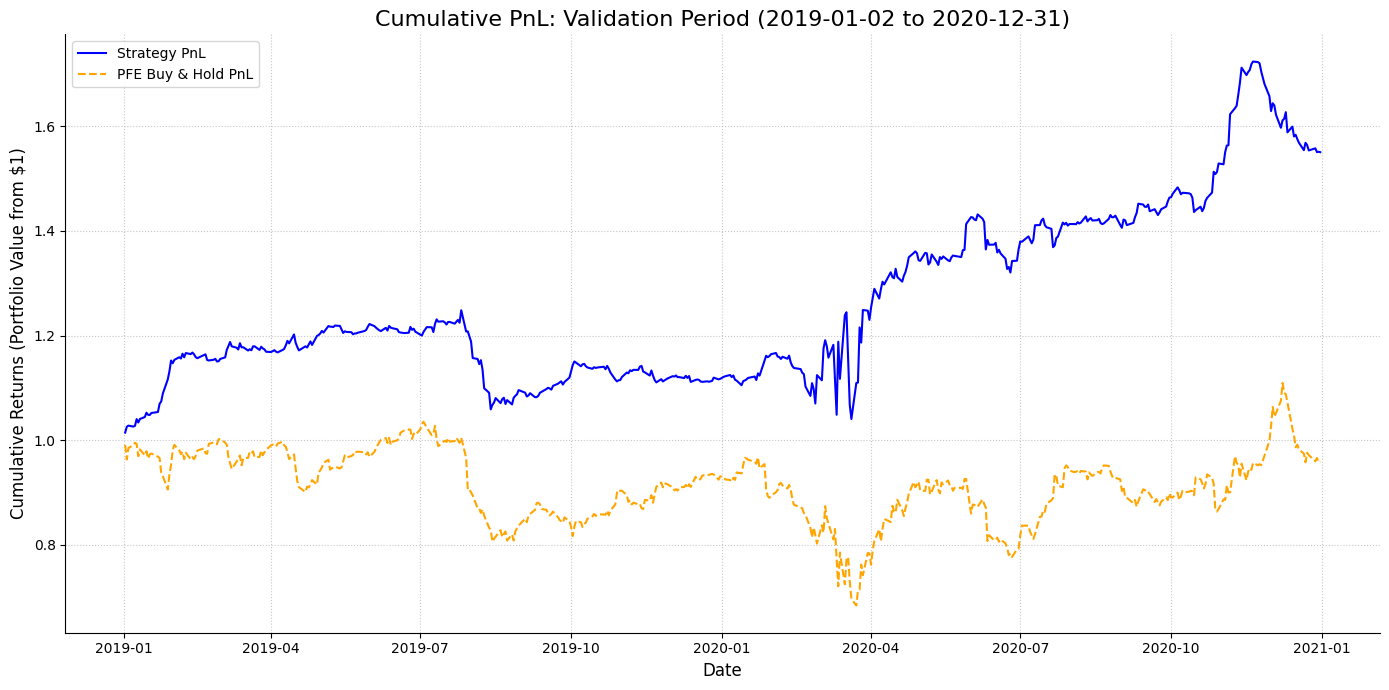


TEST PERIOD (2021-01-04 to 2025-04-14):
Total Return: 19.78%
Annual Return: 4.32%
Volatility: 14.52%
Sharpe Ratio: 0.29770160870176754
Max Drawdown: -26.90%
Win Rate: 52.00%
Baseline Total: -27.30%
Baseline Annual: -7.20%
Outperformance: 11.52%
N Trades: 1075


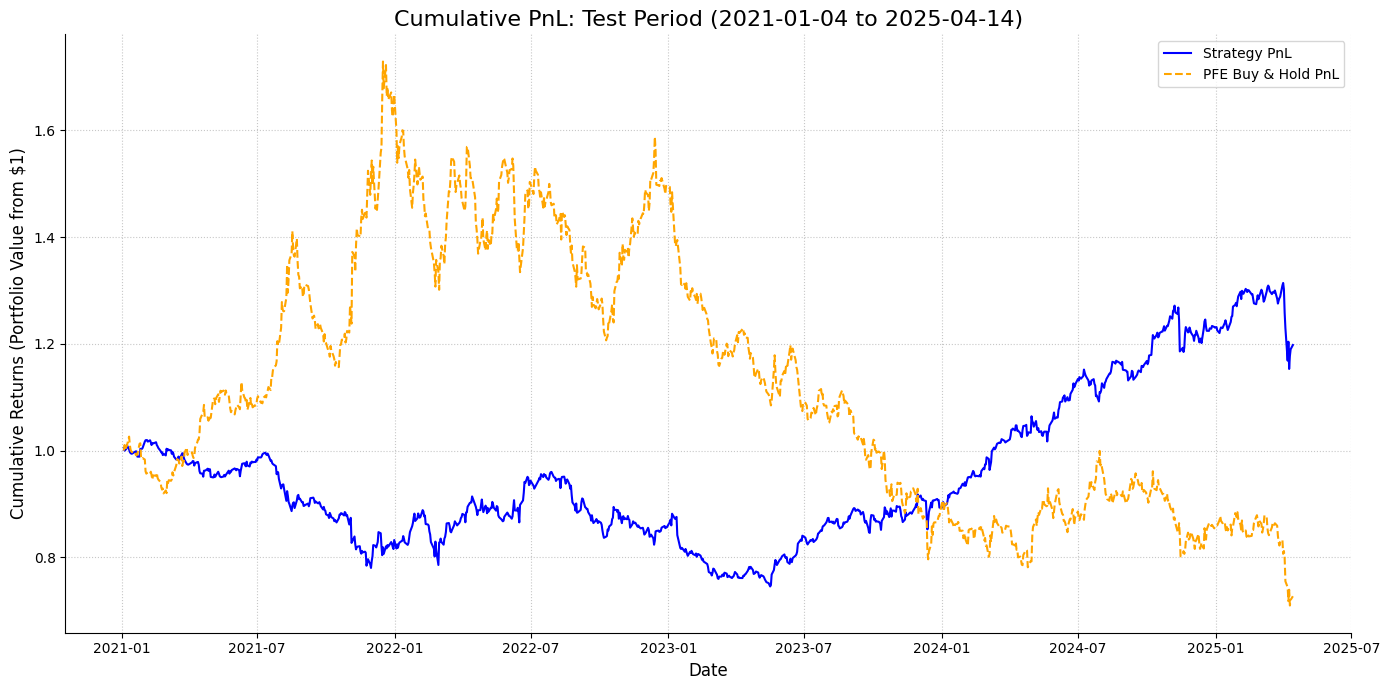

In [11]:
if __name__ == '__main__':
    main()